# CESM-LE analysis
### Looks and changes on rain on snow events over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily FSNO & RAIN
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18) 
#    to allow dask to allocate more memory to each worker"
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [16]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:43111 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [17]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr<=2014:
            mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir+'*BSSP370cmip6.f09_g17.LE2-13*')) # hack to get SSPs
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10*int(yr/10)+5
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'

        if yr>2009:
            if yr<2014:
                yy = '.20100101-20141231.'
        if yr>=2095:
            yy = '.20950101-21001231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff

In [18]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear,2009,10),2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear),2094,10),2095]

        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
        #print(files)
    return files

In [19]:
def get_daily(model,fields,firstyear, component,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(files[0],combine='by_coords',
                                       parallel=True,chunks={'time':500})
                tmp = xr.open_dataset(files[0][0],chunks={'time':500})
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks={'time':500})

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks={'time':500})
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [20]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [21]:
%%time

lnd_vars = ['RAIN','FSNO','SNOWDP','TSOI']
model = 'CESM2'
firstyear = 2000
component = 'lnd'
nens = 5  # read in 10 ensemble members for now
dsHIST = get_daily(model,lnd_vars,firstyear, component,nens)
print()

firstyear = 2085
dsSSP = get_daily(model,lnd_vars,firstyear, component,nens)


CPU times: user 2.83 s, sys: 231 ms, total: 3.06 s
Wall time: 8.18 s


CPU times: user 152 ms, sys: 25.3 ms, total: 177 ms
Wall time: 2.87 s


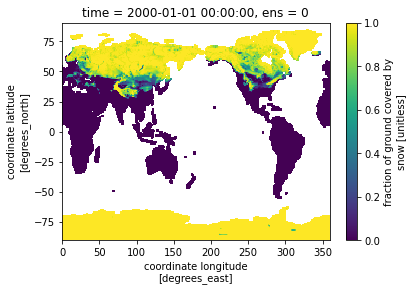

In [22]:
%%time
# subset data to get soil temp at ~10 cm 
#print(dsHIST['TSOI'])
dsHIST['TSOI'] = dsHIST['TSOI'].isel(levgrnd=2)
dsSSP['TSOI'] = dsSSP['TSOI'].isel(levgrnd=2)


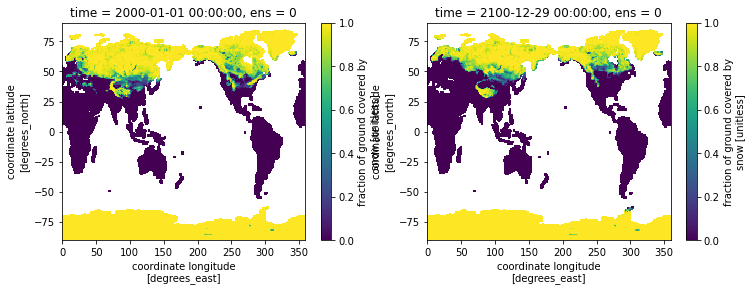

In [25]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
dsHIST[lnd_vars[1]].isel(ens=0,time=0).plot();   
plt.subplot(1,2,2)
dsSSP[lnd_vars[1]].isel(ens=0,time=-1).plot();   

In [26]:
# mask out grids what are always 100% snow covered
dsHIST = dsHIST.where(dsHIST['FSNO'].min(['time','ens'])< 1.)
dsSSP  = dsSSP.where(dsSSP['FSNO'].min(['time','ens'])< 1.)

In [27]:
# for speed, lets just look a single grid cell, here in CO
# maybe avoid loading data into memory, as this seems to kill workers with TSOI data added.

plat, plon = 39,253  #-25, 150
ds = dsHIST.sel(lat=plat,lon=plon, method='nearest')#.load()
ds2 = dsSSP.sel(lat=plat,lon=plon, method='nearest')#.load()

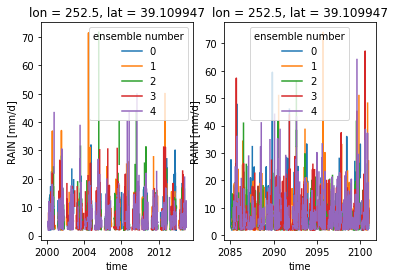

In [28]:
# convert rain to daily flux
s2d = 3600 * 24   # convert seconds to days
ds['RAIN'] = ds.RAIN * s2d
ds2['RAIN'] = ds2.RAIN * s2d
ds['RAIN'].attrs['units'] = 'mm/d'
ds2['RAIN'].attrs['units'] = 'mm/d'

# mask out events < 2 mm day
ds['RAIN'] = ds['RAIN'].where(ds['RAIN']>2)
ds2['RAIN'] = ds2['RAIN'].where(ds2['RAIN']>2)

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
ds.RAIN.plot(hue='ens');
plt.subplot(1,2,2)
ds2.RAIN.plot(hue='ens');

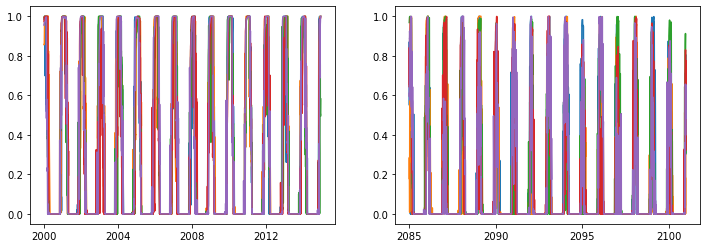

In [29]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
for i in range(nens):
    plt.plot(ds.time,ds.FSNO.isel(ens=i));
plt.subplot(1,2,2)
for i in range(nens):
    plt.plot(ds2.time,ds2.FSNO.isel(ens=i));

### Plot annual averages (across ensembles) for each time period
- snow depth and 
- 10 cm soil temperatutres 

KilledWorker: ("('open_dataset-b1fa1e6305cafd1f5be2be05b02f04beTSOI-259a925a02d44e5e41909949d193fb0b', 0, 0, 0, 0)", <Worker 'tcp://10.12.205.25:43559', name: 0-26, memory: 0, processing: 1>)

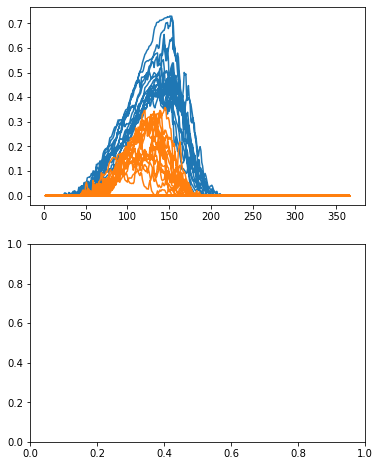

In [30]:
import matplotlib.dates as mdates

# determine the water year
# !! This approach puts Octoberr 1 as DOY=1, but then the previous Jan moves to then end of the year
### try using shift instead?

ds['day_water_year'] = xr.where(ds.time.dt.dayofyear<=274,ds.time.dt.dayofyear+(365-273),ds.time.dt.dayofyear-273)
MonthShift = (xr.where(ds.time.dt.month<=10,ds.time.dt.month+3,ds.time.dt.month-9))
ds2['day_water_year'] = xr.where(ds2.time.dt.dayofyear<=274,ds2.time.dt.dayofyear+(365-273),ds2.time.dt.dayofyear-273)

plt.figure(figsize=[6,8])

plt.subplot(2,1,1)
plt.plot(ds['day_water_year'], ds.SNOWDP.mean(dim=['ens']))
plt.plot(ds2['day_water_year'], ds2.SNOWDP.mean(dim=['ens']))

plt.subplot(2,1,2)
plt.plot(ds['day_water_year'], ds.TSOI.mean(dim=['ens']))
plt.plot(ds2['day_water_year'], ds2.TSOI.mean(dim=['ens']))

### unsure how to adjust dates for water year (Oct-Sept)
tempTime = pd.date_range('2001-10-01', '2002-09-30', freq='m')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
print(tempTime)
#X = plt.gca().xaxis
#X.set_major_locator(locator)
# Specify formatter
#X.set_major_formatter(fmt)
plt.show();

### Calculate number of rain on snow days...

<xarray.DataArray 'time' ()>
array(cftime.DatetimeGregorian(2010, 1, 11, 0, 0, 0, 0), dtype=object)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11
    time     object 2010-01-11 00:00:00


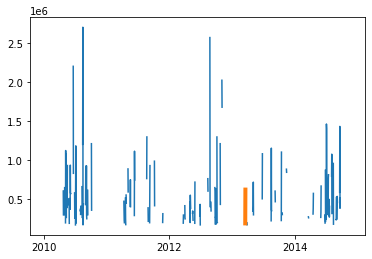

In [193]:
minFSNO = 0.4
minSNOWDP = 0.1
ds['RAINonSNOW'] = ds.RAIN.where(ds.FSNO>minFSNO)
ds2['RAINonSNOW'] = ds2.RAIN.where(ds2.FSNO>minFSNO)
#ds['RAINonSNOW'] = ds.RAIN.where(ds.SNOWDP>minSNOWDP)
plt.plot(ds.time,ds['RAIN'].isel(ens=2))
plt.plot(ds.time,ds['RAINonSNOW'].isel(ens=2),lw=4);

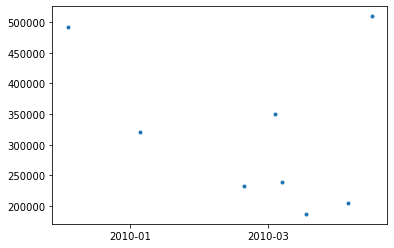

In [194]:
plt.plot(ds['time'].isel(time=slice(0,365)), ds['RAINonSNOW'].isel(ens=2,time=slice(0,365)),'.' );

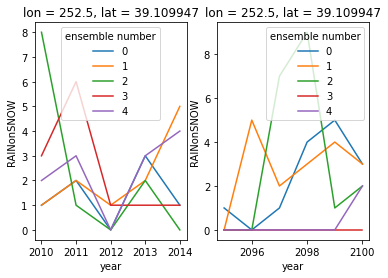

In [195]:
RS_yearHIST = ds['RAINonSNOW'].groupby('time.year').count(dim='time')
RS_yearSSP = ds2['RAINonSNOW'].groupby('time.year').count(dim='time')
plt.subplot(1,2,1)
RS_yearHIST.plot(hue='ens');
plt.subplot(1,2,2)
RS_yearSSP.plot(hue='ens');

In [141]:
print(RS_year.mean(dim='ens'))

<xarray.DataArray 'RAINonSNOW' (year: 5)>
array([3. , 2.8, 0.4, 2.2, 2.2])
Coordinates:
    lon      float32 252.5
    lat      float32 39.11
  * year     (year) int64 2010 2011 2012 2013 2014


CPU times: user 27.8 ms, sys: 1.99 ms, total: 29.8 ms
Wall time: 28.6 ms


Text(0, 0.5, 'acc_NI')

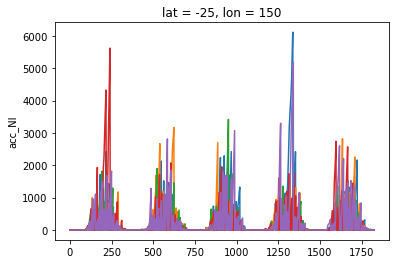

In [38]:
%%time 
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work, 
#    not so much for the numpy example...

# select single grid cell
for i in range(nens):
    ## if single point already selected
    v = pd.Series(ds['d_NI'].isel(ens=i).values)
    
    # or to look at a single point here
    plat, plon = -25, 150
    #v = pd.Series(ds['d_NI'].sel(lat=plat,lon=plon, method='nearest').isel(ens=i).values)

    # Then continue with pandas cumsum example 
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()

    plt.plot(result)

plt.title('lat = '+str(plat)+', lon = '+str(plon))
plt.ylabel('acc_NI');

Time isn't being handled correctly for some reason...

How does this get built out efficiently in xarray?  
- likely need to use ufunc

## Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1821   NaN
1822   NaN
1823   NaN
1824   NaN
1825   NaN
Length: 1826, dtype: float32


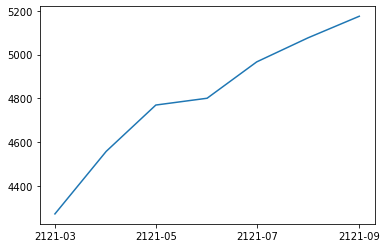

In [42]:
ex = result.where(result>4000)
print(ex)
plt.plot(ds.time,ex);
# eventaully could calculate the number of days / year where fire risk is moderate, high, extreme & compare change over time

### Sanity check, look at daily and accumulated NI for single ensemble member

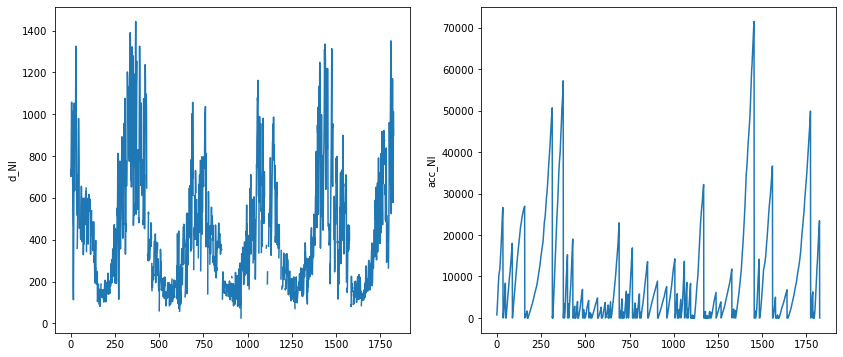

In [24]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.plot(v)
plt.ylabel('d_NI')
plt.subplot(1,2,2)
plt.plot(result)
plt.ylabel('acc_NI');

In [ ]:
print(ds.time['time'])

In [25]:
ds['d_NI'].isel(time=0,ens=0).plot()

KilledWorker: ("('where-getitem-6badac1209ef9884dd3066bfb93a482b', 0, 0)", <Worker 'tcp://10.12.205.31:43743', name: 0-9, memory: 0, processing: 1>)

In [37]:
print(v)

NameError: name 'v' is not defined